# Model Interpretability with Grad-CAM

Visualize where trained models focus their attention using Grad-CAM (Gradient-weighted Class Activation Mapping) on TACO and Original datasets.

In [11]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

TACO_ROOT = '../TACO/data' 

TACO_ANNOTATIONS = '../TACO/data/annotations.json' 


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [12]:
class ManualGradCAM:
    """Grad-CAM implementation for model interpretability."""
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, input_tensor, target_class_idx):
        # Forward pass
        output = self.model(input_tensor)
        
        # Backward pass
        self.model.zero_grad()
        score = output[0, target_class_idx]
        score.backward()
        
        # Get captured data
        gradients = self.gradients
        activations = self.activations
        
        # Calculate weights using global average pooling
        weights = torch.mean(gradients, dim=[2, 3], keepdim=True)
        
        # Weighted combination of feature maps
        cam = torch.sum(weights * activations, dim=1).squeeze()
        
        # Apply ReLU and normalize
        cam = F.relu(cam)
        cam = cam - torch.min(cam)
        cam = cam / (torch.max(cam) + 1e-8)
        
        return cam.cpu().detach().numpy(), output

# Helper function to overlay heatmap on image
def overlay_cam(img_tensor, heatmap):
    """Overlay Grad-CAM heatmap on the original image."""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    img = img_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    # Resize heatmap to match image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # Apply color map
    heatmap_uint8 = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    img_uint8 = np.uint8(255 * img)
    
    # Blend images
    superimposed = cv2.addWeighted(heatmap_color, 0.4, img_uint8, 0.6, 0)
    
    return cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB), img

In [13]:
import json

class TacoTestDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.samples = [] 

        self.taco_map = {
            # Cardboard (0)
            'Cardboard': 0, 'Carton': 0, 'Corrugated carton': 0, 'Pizza box': 0, 
            'Drink carton': 0, 'Egg carton': 0, 'Toilet tube': 0,
            # Glass (1)
            'Glass bottle': 1, 'Broken glass': 1, 'Glass jar': 1,
            # Metal (2)
            'Aluminium foil': 2, 'Drink can': 2, 'Food can': 2, 'Metal bottle cap': 2, 
            'Aerosol': 2, 'Scrap metal': 2, 'Pop tab': 2, 'Metal lid': 2,
            # Paper (3)
            'Paper': 3, 'Paper bag': 3, 'Newspaper/magazine': 3, 'Scrap paper': 3, 
            'Notebook': 3, 'Receipt': 3, 'Paper cup': 3,
            # Plastic (4)
            'Clear plastic bottle': 4, 'Other plastic bottle': 4, 'Plastic bottle cap': 4, 
            'Plastic lid': 4, 'Plastic straw': 4, 'Plastic bag & wrapper': 4, 'Polystyrene': 4, 
            'Plastic cup': 4, 'Disposable plastic cup': 4, 'Tupperware': 4, 'Squeezable tube': 4, 
            'Plastic film': 4, 'Six pack rings': 4, 'Garbage bag': 4, 'Plastic utensils': 4
        }

        # Load Annotations
        with open(annotation_file, 'r') as f:
            data = json.load(f)

        cats = {c['id']: c['name'] for c in data['categories']}
        imgs = {i['id']: (i['file_name'], i['width'], i['height']) for i in data['images']}

        # Filter valid images
        for ann in data['annotations']:
            cat_name = cats[ann['category_id']]
            if cat_name in self.taco_map:
                target = self.taco_map[cat_name]
                
                # Get Image Info
                img_name, img_w, img_h = imgs[ann['image_id']]
                img_path = self.root_dir / img_name
                
                # Get BBox [x, y, w, h]
                bbox = ann['bbox'] 
                x, y, w, h = bbox

                if w < 60 or h < 60:
                    continue
                            
                if w <= 1 or h <= 1:
                    continue
                    
                if x >= img_w or y >= img_h:
                    continue

                if img_path.exists():
                    self.samples.append((str(img_path), bbox, target))

        print(f"TACO Dataset initialized: Found {len(self.samples)} valid samples.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, bbox, label = self.samples[idx]
        
        image = Image.open(path).convert('RGB')
        img_w, img_h = image.size

        x, y, w, h = bbox
        
        center_x = x + w / 2
        center_y = y + h / 2
        max_dim = max(w, h) * 1.2 
        
        new_w = max_dim
        new_h = max_dim
        
        left = int(center_x - new_w / 2)
        top = int(center_y - new_h / 2)
        right = int(center_x + new_w / 2)
        bottom = int(center_y + new_h / 2)
        

        left = max(0, min(left, img_w - 1))
        top = max(0, min(top, img_h - 1))
        right = max(left + 1, min(right, img_w))     
        bottom = max(top + 1, min(bottom, img_h))   

        crop = image.crop((left, top, right, bottom))
        
        if self.transform:
            crop = self.transform(crop)
        
        return crop, label

In [14]:
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


taco_dataset = TacoTestDataset(TACO_ROOT, TACO_ANNOTATIONS, transform=test_transforms)
taco_loader = DataLoader(taco_dataset, batch_size=32, shuffle=False)

TACO Dataset initialized: Found 2000 valid samples.


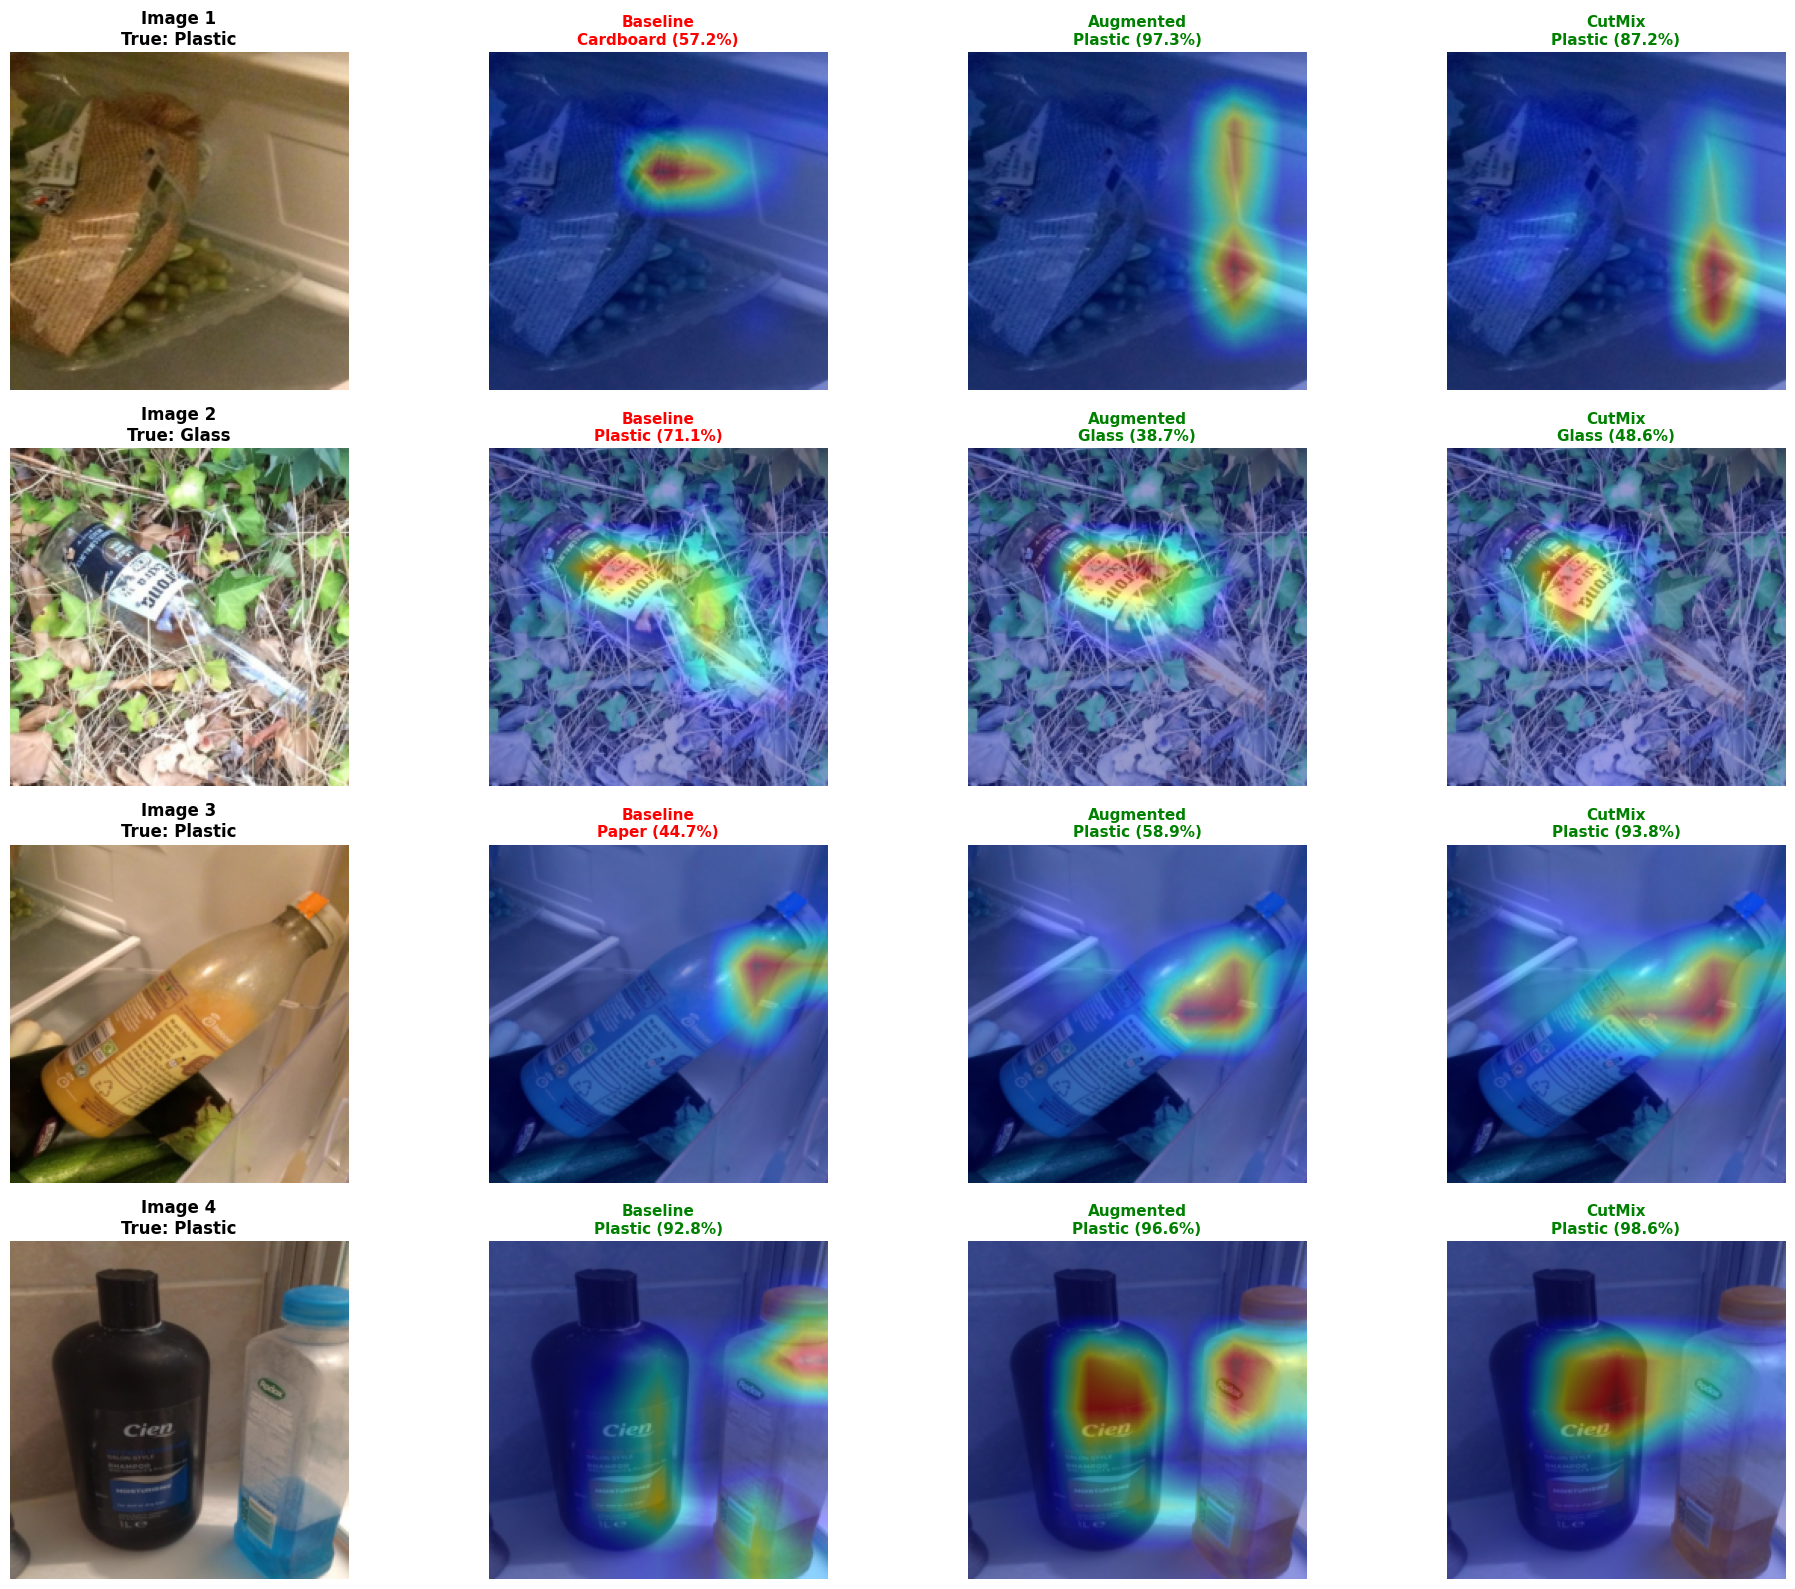

In [ ]:
# Load trained models
def load_trained_model(path, num_classes=5):
    model = models.resnet50(weights=None) 
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    
    # Load weights
    checkpoint = torch.load(path, map_location=device)
    if 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint
    
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('fc.1.'):
            new_key = k.replace('fc.1.', 'fc.')
            new_state_dict[new_key] = v
        else:
            new_state_dict[k] = v
    
    model.load_state_dict(new_state_dict)
    model.to(device)
    model.eval()
    return model

model_baseline = load_trained_model('../best_model/best_resnet50_baseline.pth')
model_augmented = load_trained_model('../best_model/best_resnet50_augmented.pth')
model_cutmix = load_trained_model('../best_model/best_resnet50_cutmix.pth')

models_dict = {
    'Baseline': model_baseline,
    'Augmented': model_augmented,
    'CutMix': model_cutmix
}

# Get sample images from TACO dataset
data_iter = iter(taco_loader)
images, labels = next(data_iter)

# Randomly select 4 images
random_indices = np.random.choice(len(images), 4, replace=False)

# Map class names
taco_classes = {0: 'Cardboard', 1: 'Glass', 2: 'Metal', 3: 'Paper', 4: 'Plastic'}

fig, axes = plt.subplots(4, 4, figsize=(20, 16))

# Process each random image
for row, image_idx in enumerate(random_indices):
    img_tensor = images[image_idx].unsqueeze(0).to(device)
    true_label = labels[image_idx].item()
    class_name = taco_classes.get(true_label, str(true_label))
    
    # Show Original Image
    _, original_img = overlay_cam(images[image_idx].unsqueeze(0), np.zeros((224, 224)))
    axes[row, 0].imshow(original_img)
    axes[row, 0].set_title(f"Image {row+1}\nTrue: {class_name}", fontsize=12, fontweight='bold')
    axes[row, 0].axis('off')
    
    # Generate Grad-CAM for each model
    for col, (name, model) in enumerate(models_dict.items()):
        grad_cam = ManualGradCAM(model, model.layer4[-1])
        heatmap, output = grad_cam.generate_heatmap(img_tensor, true_label)
        vis_image, _ = overlay_cam(img_tensor, heatmap)
        
        # Get prediction confidence
        probs = F.softmax(output, dim=1)
        conf, pred = torch.max(probs, 1)
        pred_class = taco_classes.get(pred.item(), str(pred.item()))
        accuracy_score = conf.item() * 100
        
        # Plot with color-coded title
        axes[row, col+1].imshow(vis_image)
        color = 'green' if pred.item() == true_label else 'red'
        axes[row, col+1].set_title(f"{name}\n{pred_class} ({accuracy_score:.1f}%)", 
                                    color=color, fontsize=11, fontweight='bold')
        axes[row, col+1].axis('off')

save_path = '../plots/taco_gradcam.png'
plt.savefig(save_path, dpi=150, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [28]:
# Load TrashNet test dataset
from torch.utils.data import Subset
import torchvision.datasets as datasets

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

data_path = '../dataset'

# Load and split dataset
full_dataset_no_transform = datasets.ImageFolder(root=data_path)
total_size = len(full_dataset_no_transform)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = int(0.2 * total_size)

torch.manual_seed(42)
indices = torch.randperm(total_size).tolist()

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

test_dataset_full = datasets.ImageFolder(root=data_path, transform=test_transform)
test_dataset = Subset(test_dataset_full, test_indices)

BATCH_SIZE = 32
NUM_WORKERS = 4
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                         num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True)

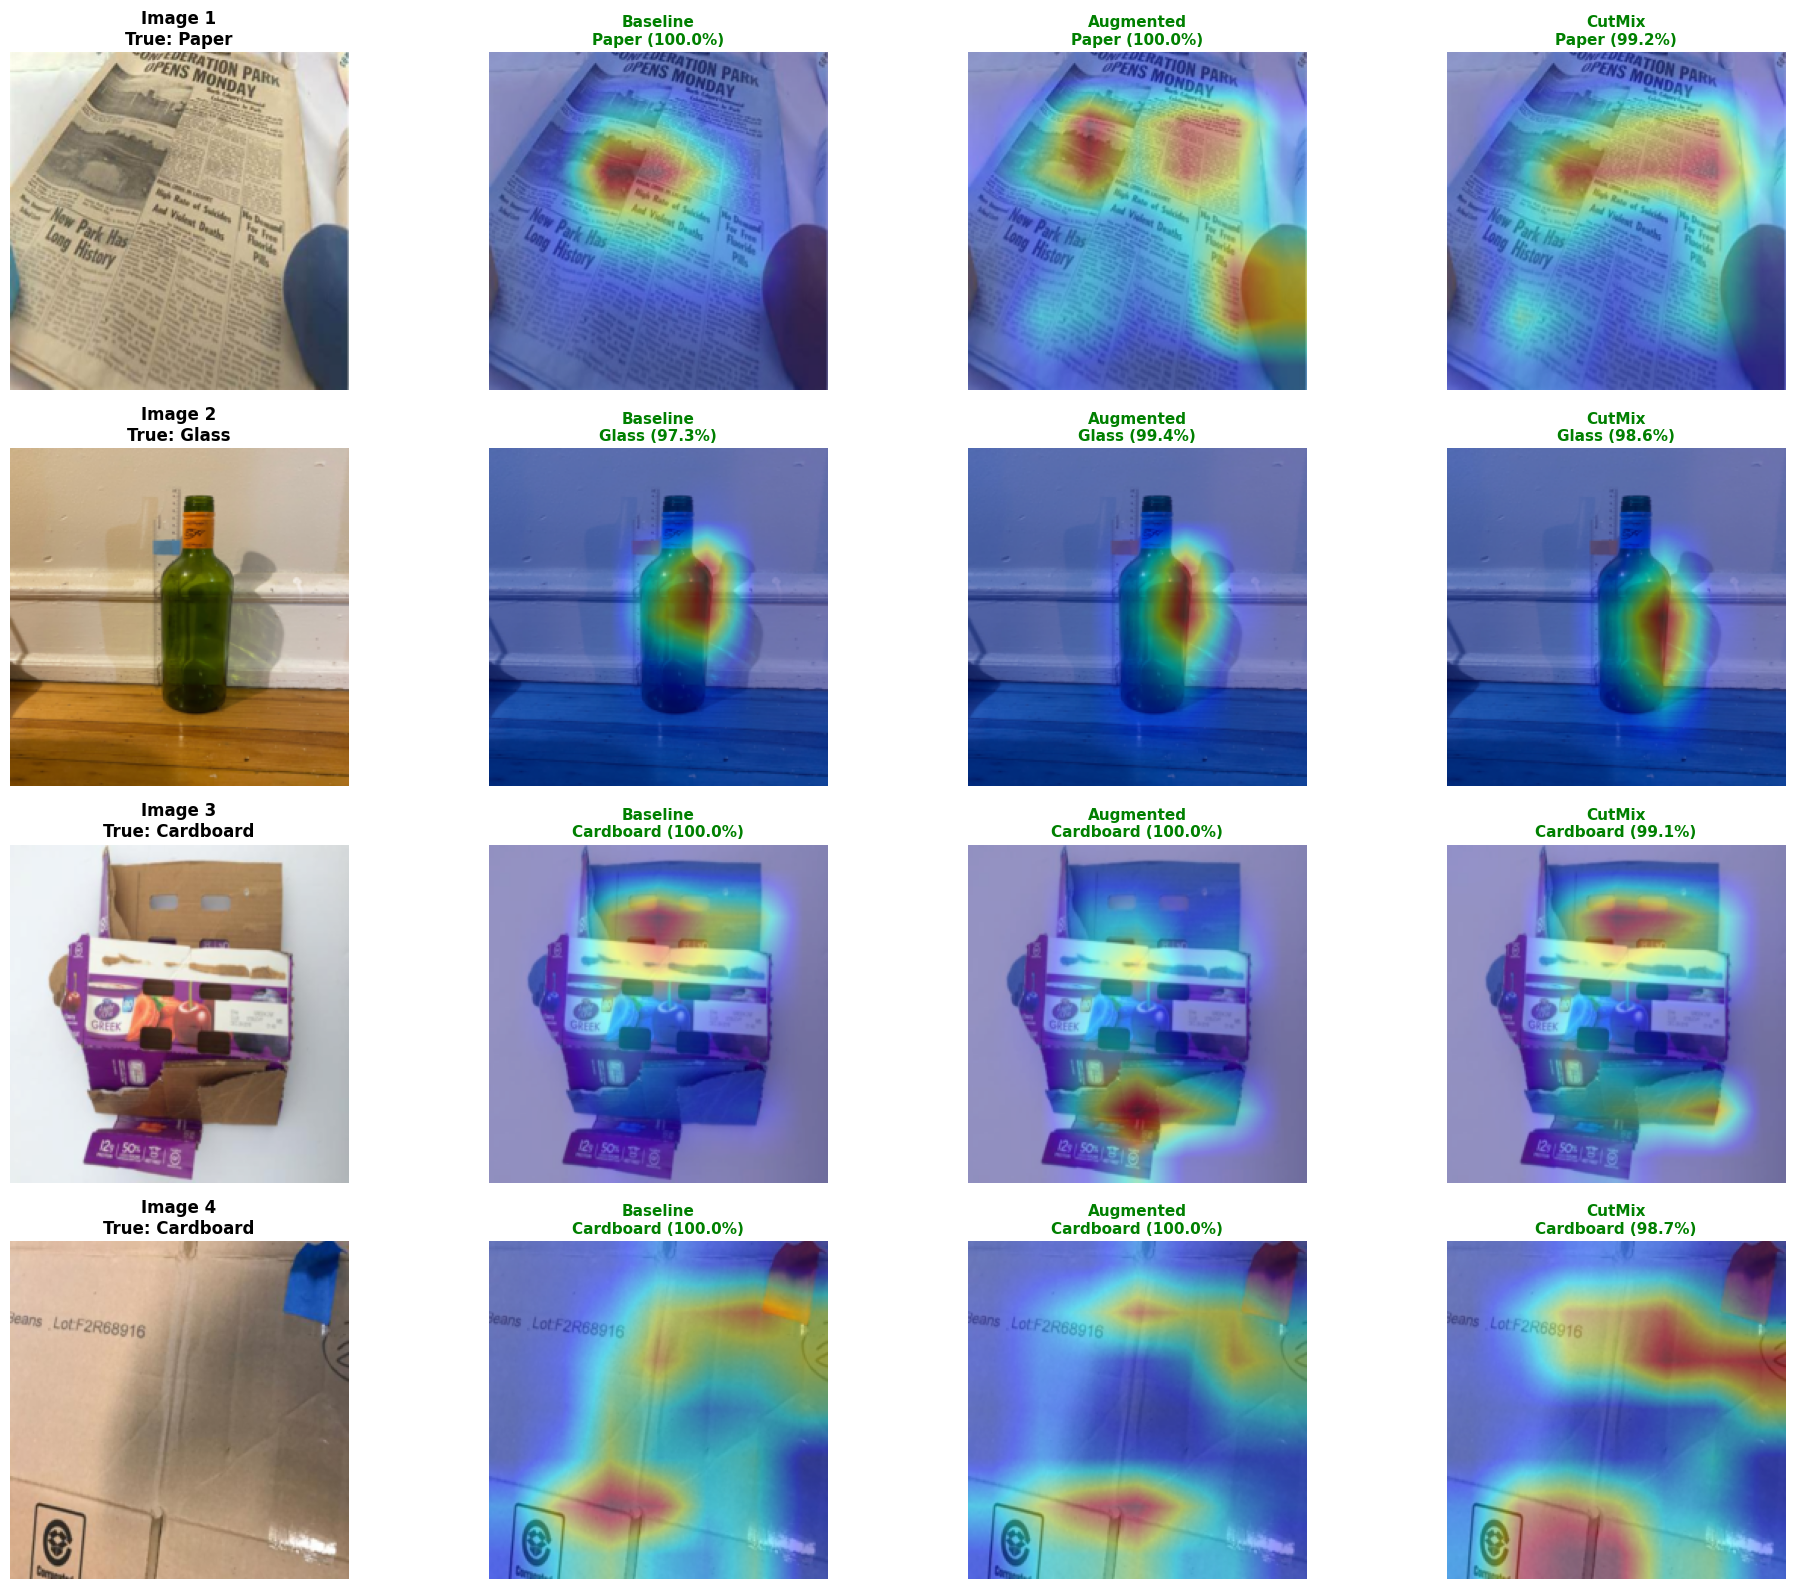

In [38]:
# Grad-CAM Visualization on dataset Test Set
class_names = {0: 'Cardboard', 1: 'Glass', 2: 'Metal', 3: 'Paper', 4: 'Plastic'}

test_iter = iter(test_loader)
images, labels = next(test_iter)

# Randomly select 4 images
random_indices = np.random.choice(len(images), 4, replace=False)

fig, axes = plt.subplots(4, 4, figsize=(20, 16))

# Process each random image
for row, image_idx in enumerate(random_indices):
    img_tensor = images[image_idx].unsqueeze(0).to(device)
    true_label = labels[image_idx].item()
    class_name = class_names.get(true_label, str(true_label))
    
    # Show Original Image
    _, original_img = overlay_cam(images[image_idx].unsqueeze(0), np.zeros((224, 224)))
    axes[row, 0].imshow(original_img)
    axes[row, 0].set_title(f"Image {row+1}\nTrue: {class_name}", fontsize=12, fontweight='bold')
    axes[row, 0].axis('off')
    
    # Generate Grad-CAM for each model
    for col, (name, model) in enumerate(models_dict.items()):
        grad_cam = ManualGradCAM(model, model.layer4[-1])
        heatmap, output = grad_cam.generate_heatmap(img_tensor, true_label)
        vis_image, _ = overlay_cam(img_tensor, heatmap)
        
        # Get prediction confidence
        probs = F.softmax(output, dim=1)
        conf, pred = torch.max(probs, 1)
        pred_class = class_names.get(pred.item(), str(pred.item()))
        confidence = conf.item() * 100
        
        # Plot with color-coded title
        axes[row, col+1].imshow(vis_image)
        color = 'green' if pred.item() == true_label else 'red'
        axes[row, col+1].set_title(f"{name}\n{pred_class} ({confidence:.1f}%)", 
                                    color=color, fontsize=11, fontweight='bold')
        axes[row, col+1].axis('off')

save_path = '../plots/dataset_gradcam.png'
plt.savefig(save_path, dpi=150, bbox_inches='tight')

plt.tight_layout()
plt.show()